# Self Attention (ViT 2020)

[Visual Transformers: Token-based Image Representation and Processing for Computer Vision (Wu et al., 2020)](https://arxiv.org/abs/2006.03677)

[Реализация](https://github.com/lucidrains/vit-pytorch)

[Блог-пост разбор  ViT](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)


**Vision Transformer** — это модель для классификации изображений, которая использует архитектуру трансформера. Попробуем разобраться, как она работает.

В 2020 году стали появляться работы, где модели на базе архитектур трансформер смогли показать результаты лучше, чем у **CNN** моделей.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/cited_vit_accuracy.png"  width="650"></center>


<center><em>Source: <a href="https://arxiv.org/abs/2010.11929">An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020</a></em></center>

BiT — это baseline модель на базе **ResNet**, ViT — **Visual Transformer**



### Недостатки сверточного слоя

Авторы практически полностью отказались от использования сверток,  заменив их слоями **self-attention**.  Попробуем понять, почему это сработало.

Добавляя в модель свёрточный слой, мы руководствуемся резонным предположением: чем ближе пиксели на изображении, тем больше будет их взаимное влияние.

В большинстве случаев это работает:

 - На слое n (красный) активируются нейроны, которые реагируют на морду и на хвост кота.

 - В карте активаций их выходы оказываются рядом, и в слое n + 1 (синий) они попадают в одну свертку, которая активируется на объектах типа "кот".

Так случается часто, но не всегда:

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/cnn_fail.jpg"  width="700"></center>

На этом изображении активации нейронов, реагирующих на морду и хвост, не попадут в одну свертку на следующем слое. Это может привести к тому, что нейрон, обучившийся реагировать на кошек, не активируется.

Причиной этого является допущение ([Inductive bias](https://en.wikipedia.org/wiki/Inductive_bias)) о взаимном влиянии соседних пикселей.

### Self-attention

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/global_attention.png"  width="900"></center>

**Self-attention** слой лишен этого недостатка. Он обучается оценивать взаимное влияние входов друг на друга. Но как применить его к изображениям?

В статье [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)](https://arxiv.org/pdf/2010.11929.pdf) предлагается разбивать картинки на кусочки (patches) размером 16x16 пикселей и подавать их на вход модели.

Проделаем это:

In [1]:
URL = "https://ml.gan4x4.ru/msu/dep-2.0/L08/cat.jpeg"
!wget -q $URL -O image.jpg

Преобразуем изображение в тензор, порежем на фрагменты и отобразим их, используя image_grid

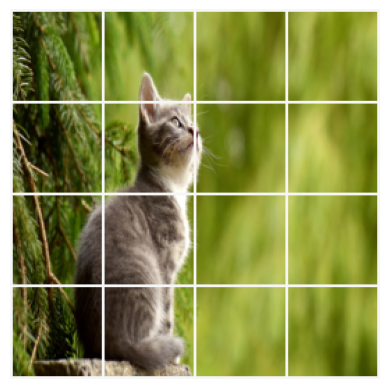

In [2]:
from torchvision import utils, transforms
import matplotlib.pyplot as plt
import torch
from PIL import Image

img = Image.open("image.jpg")

transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

img = transform(img)
patches = []
sz = 64
for r in range(0, img.shape[1], sz):
    for c in range(0, img.shape[2], sz):
        patches.append(img[:, r : r + sz, c : c + sz])

patches = torch.stack(patches).type(torch.float)

img_grid = utils.make_grid(patches, pad_value=10, normalize=True, nrow=4)
plt.imshow(transforms.ToPILImage()(img_grid).convert("RGB"))
plt.axis("off")
plt.show()

На вход модели они поступят в виде вектора:

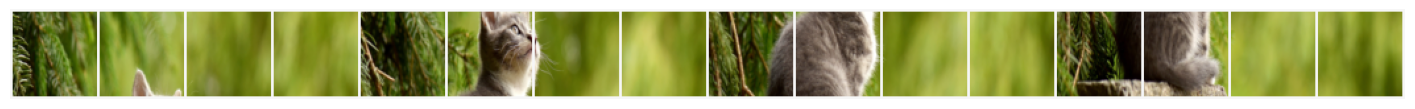

In [3]:
plt.figure(figsize=(18, 6))
img_grid = utils.make_grid(patches, pad_value=10, normalize=True, nrow=256 // 16)
plt.imshow(transforms.ToPILImage()(img_grid).convert("RGB"))
plt.axis("off");

Затем последовательность из фрагментов изображения передается в модель, где после ряда преобразований попадает на вход слоя **self-attention**:

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/self_attention.png"  width="900"></center>

Картинки приведены исключительно для наглядности, в действительности слой работает с векторами признаков, которые не визуализируются столь очевидно. Однако кэффициенты, с которыми складываются вектора-признаков, отражают важность каждого с учетом всех остальных входов.



## Сравнение со сверткой

<img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/conv_vs_self_attention1.png" width="400">

При свертке каждый признак умножается на свой вес, и затем они суммируются. Важно что вклад взвешенных признаков в сумму не зависит от контекста.

То есть ягода клубники, лежащая на столе (где рядом с ней может быть все, что угодно), даст такой же вклад в сумму, как и ягода с клубничного куста.



<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/conv_vs_self_attention2.png"  width="900"></center>

Слой self-attention выполняет ту же задачу, что и свертка: получает на вход вектор признаков и возвращает другой, более информативный.  Но делает это более умно:





<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/conv_vs_self_attention3.png"  width="900"></center>

*Вместо чисел здесь вектора, но принципильно это ничего не меняет, можно применить self-attention и к отдельным признакам (яркостям, пикселям), просто для это потребуется очень много ресурсов.*

**Каждый признак** участвует в каждой сумме, а не только те, что попали в рецептивное поле фильтра.
Кроме этого, суммируются они с коэффициентами $a$, которые **зависят от входов** и различны для каждой суммы.

Для получения этих коэффициентов и нужна большая часть слоя self-attention. На рисунке выделено красным.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/conv_vs_self_attention5.png"  width="900"></center>

#### Как получить веса внимания?

In [4]:
import torch
import torch.nn as nn


class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = scores.softmax(dim=2)
        print("Scores shape", scores.shape)
        weighted = torch.bmm(attention, values)
        return weighted

In [5]:
embed_dim = 256
self_attention_layer = SelfAttention(embed_dim)
dummy_x = torch.randn(1, 4 * 4, embed_dim)  # Batch_size x Sequence_len x Embedding_size
out = self_attention_layer(dummy_x)
print(out.shape)

Scores shape torch.Size([1, 16, 16])
torch.Size([1, 16, 256])


#### Соображения относительно размера patch

Трансформеры работают с последовательностями за счёт механизма внимания (**self-attention**). И чтобы подать на вход изображение, требуется превратить его в последовательность.

Сделать это можно разными способами, например, составить последовательность из всех пикселей изображения. Её длина $n =  H*W$ (высота на ширину)

[Сложность вычисления](https://www.researchgate.net/figure/Compare-the-computational-complexity-for-self-attention-where-n-is-the-length-of-input_tbl7_347999026) одноголового слоя **self-attention** $O(n^2 d )$,  где $n$ — число токенов и $d$ — размерность входа (embedding)  (для любознательных расчеты [тут](https://stackoverflow.com/questions/65703260/computational-complexity-of-self-attention-in-the-transformer-model)).

То есть для квадратных изображений $(H==W)$ получим $O(H^3 d )$

1. Такой подход будет очень вычислительно сложен.

2. Интуитивно понятно, что кодировать каждый пиксель относительно большим embedding-ом не очень осмысленно.


*Для тех, кто забыл, напомним что $O()$ — это Big O notation, которая отражает ресурсы, требуемые для вычисления. Так для $O(1)$ — время вычисления будет постоянным, вне зависимости от количества данных, а для $O(N)$ — расти пропорционально количеству данных.*


Разберём на примере: Допустим, мы используем трансформер для предложения длиной в 4 слова — "Мама мылом мыла раму" => у нас есть `4 токена`. Закодируем их в *embeddings* с размерностью `256`. Потребуется порядка $4^2*256 = 4096$ операций.

А теперь попробуем провернуть то же самое для картинки размерами 256 на 256.
Количество токенов

 $256^3*256  = 256^4 =  4 294 967 296 $. Упс... Кажется, нам так никаких ресурсов не хватит — трансформеры с картинками использовать.



Посчитаем сложность для картинки размером 256x256, разбитой на кусочки по 16px. при том же размере токена (256) $n = 16$.
$16^2*256 = 256^2 = 65536 $. И впрямь! ~65000 раз меньше ресурсов требуется.

[Как устроен  self-attention](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

[Self-attention слой в PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)

### Position embedding

Не теряем ли мы важной информации, разбивая изображение на фрагменты? На первый взгляд кажется, что модель сможет научиться восстанавливать порядок, в котором фрагменты шли в исходном изображении.

Всегда ли?

Рассмотрим пример изображения, где нет ярко выраженной текстуры:

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/positional_transformer_explanation.png"  width="500"></center>

На рисунке а) наковальня падает на ребенка, на рисунке б) ребенок прыгает на наковальне.

Суть принципиально отличается, но что будет, если составить из фрагментов любого изображения набор патчей:

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.0/L08/positional_vec_transformer_explanation.png"  width="500"></center>

Восстановить по нему можно будет любой из вариантов!

Так как **self-attention** блок никак не кодирует позицию элемента на входе, то важная информация потеряется.

Чтобы избежать таких потерь, информацию, кодирующую позицию фрагмента (patch),  добавляют к входным данным **self-attention** слоя в явном виде.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.0/L08/out/linear_projection_of_flattened_patches.png"  width="600"></center>

Методы для кодирования позиции:

[Sin/Cos](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) - вектор заполняется значениями sin и cos, не обучается

[nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) - учится вместе с моделью.

Размер вектора кодирующего позицию обычно равен размеру эибеддинга

# Архитектура ViT

Теперь мы можем грузить наши изображения в **Vi**sual **T**ransformer.

**Self-attention** блок мы разобрали, остальные блоки модели нам знакомы:

> **MLP** (Multi layer perceptron) — Блок из одного или нескольких линейных слоев

> **Norm** — Layer Normalization

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.0/L08/out/visual_transformer_architecture.png"  width="1000"></center>
<center><em>Архитектура Visual Transformer </em></center>



1.   Изображение режется на фрагменты (patch).
2.   Фрагменты (patch) подвергаются линейной проекции с помощью **MLP**.
3.   С полученными на выходе **MLP** векторами конкатенируются **positional embeddings** (кодирующие информацию о позиции path, как и в обычном трансформере для текста).
4. К полученным векторам добавляют еще один **0***, который называют **class embedding**.

Любопытно, что для предсказания класса используется только выход. Он соответствует дополнительному **class embedding**.  Остальные выходы (а для каждего токена в трансформере есть свой выход) отбрасываются за ненадобностью.

В финале этот специальный токен **0*** прогоняют через **MLP** и предсказывают классы.

Попробуем провести аналогию со свертками. Если рассмотреть сверточную сеть без слоев пулинга и других способов изменения пространственных размеров карт признаков, то можно считать такую сеть механизмом постепенно улучшаюшем качество признаков.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.0/L08/out/selfattention_feature_flow.png"  width="900"></center>

## Предсказание с помощью ViT


Используем пакет [ViT PyTorch](https://pypi.org/project/pytorch-pretrained-vit/)



In [6]:
!pip install -q pytorch_pretrained_vit

  Preparing metadata (setup.py) ... done


В пакете доступны несколько [предобученных моделей](https://github.com/lukemelas/PyTorch-Pretrained-ViT#loading-pretrained-models):

B_16, B_32, B_16_imagenet1k, ...



In [7]:
from pytorch_pretrained_vit import ViT
from torchvision import transforms

model = ViT("B_16_imagenet1k", pretrained=True)
model.eval()

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:02<00:00, 135MB/s]


Loaded pretrained weights.


ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
 

In [8]:
# Load image
!wget  https://ml.gan4x4.ru/msu/dep-2.0/L08/capybara.jpg

--2024-11-11 07:03:32--  https://ml.gan4x4.ru/msu/dep-2.0/L08/capybara.jpg
Resolving ml.gan4x4.ru (ml.gan4x4.ru)... 212.24.105.216
Connecting to ml.gan4x4.ru (ml.gan4x4.ru)|212.24.105.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 310456 (303K) [image/jpeg]
Saving to: ‘capybara.jpg’

capybara.jpg        100%[===================>] 303.18K   281KB/s    in 1.1s    

2024-11-11 07:03:34 (281 KB/s) - ‘capybara.jpg’ saved [310456/310456]



In [9]:
capybara_in_pil = Image.open("capybara.jpg")
transforms = transforms.Compose(
    [
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
capybara_in_tensor = transforms(capybara_in_pil)
print(capybara_in_tensor.shape)  # torch.Size([1, 3, 384, 384])

# Classify
with torch.no_grad():
    outputs = model(capybara_in_tensor.unsqueeze(0))
print(outputs.shape)  # (1, 1000)

torch.Size([3, 384, 384])
torch.Size([1, 1000])


Давайте посмотрим, что нам предсказывает ViT. Для этого подгрузим dict с переводом индексов в человеческие названия:

In [ ]:
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagenet_class_index.json

In [13]:
import json
import numpy as np


with open("imagenet_class_index.json") as f:
    imagenet_labels = json.load(f)

classes = np.array(list(imagenet_labels.values()))[:, 1]

И, собственно, переведем индекс в название:

Top 3 predictions:
337 beaver
336 marmot
338 guinea_pig


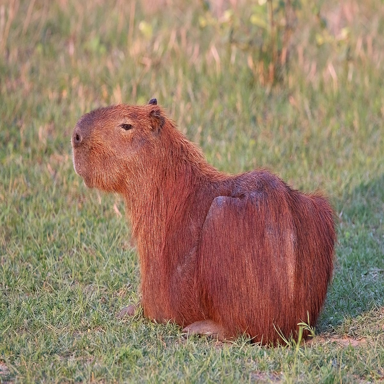

In [14]:
top3 = outputs[0].topk(3).indices
top3 = top3.tolist()


print("Top 3 predictions:")
for class_num in top3:
    print(class_num, classes[class_num])
display(capybara_in_pil.resize((384, 384)))

Ну что ж, почти (капибар в классах ImageNet 1k, как вы могли догадаться, просто нет).